# Trabalho Prático 02 - Boosting
- Thiago Martin Poppe
- 2017014324

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Lendo os dados

- Leitura dos dados do dataset Tic-Tac-Toe, que representa uma possível configuração do tabuleiro de Jogo da Velha aonde o jogador X joga primeiro.<br><br>

- Os dados possuem 9 features, sendo elas cada célula do Jogo da Velha.
    - Cada feature assume 1 dentre 3 valores, podendo ser:
        - x: o jogador X escolheu aquela posição.
        - o: o jogador O escolheu aquela posição.
        - b: posição vazia.<br><br>

- Possuímos apenas 2 classes nesse dataset, sendo elas:
    - positive: o jogador X ganha a partida.
    - negative: o jogador X perde a partida.

In [2]:
columns = [
    "top_lft", "top_mid", "top_rgt",
    "mid_lft", "mid_mid", "mid_rgt",
    "btm_lft", "btm_mid", "btm_rgt",
    
    "class"
]

data = pd.read_table("tic-tac-toe.data", sep=",", names=columns)
data

,top_lft,top_mid,top_rgt,mid_lft,mid_mid,mid_rgt,btm_lft,btm_mid,btm_rgt,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
5,x,x,x,x,o,o,b,b,o,positive
6,x,x,x,x,o,b,o,o,b,positive
7,x,x,x,x,o,b,o,b,o,positive
8,x,x,x,x,o,b,b,o,o,positive
9,x,x,x,x,b,o,o,o,b,positive


In [3]:
print("Number of positive classes:", (data["class"] == "positive").sum())
print("Number of negative classes:", (data["class"] == "negative").sum())

Number of positive classes: 626
Number of negative classes: 332


# Validação Cruzada
- Usaremos a classe KFold, disponível em ``sklearn.model_selection``, para realizar a validação cruzada com 5-folds.<br><br>

- Note que temos um desbalanceamento das classes no dataset. Temos aproximadamente o dobro de classes positivas em relação às classes negativas, que além disso estão todas juntas.<br><br>

- Devido a esse motivo, julguei importante utilizar KFold com ``shuffle=True`` para garantir que as classes estejam misturadas durante o treino e validação. Fixei a semente em 42 para que o mesmo comportamento se repita em outras execuções do Notebook.

In [4]:
# Retriving X and y
X = data.drop("class", axis=1)
y = data["class"].replace(["positive", "negative"], [1, -1]) # y must be either 1 or -1

X = X.values
y = y.values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("Number of folds =", kf.get_n_splits())

Number of folds = 5


# Classe Stump

- Um Stump, ou Decision Stump, é um modelo de classificação fraco que consiste em ser basicamente uma Árvore de Decisão com altura igual à 1 e 2 folhas. Com isso, conseguimos deduzir de onde veio esse nome, visto que Stump é uma tradução literal de tronco de árvore.<br><br>

- Modelei um Stump como uma classe para facilitar o uso do mesmo ao longo do algoritmo do AdaBoost. Nela, teremos 3 parâmetros onde 2 podem ser opcionais:
    - feature: representa sobre qual feature estaremos aplicando o Stump.
    - value: representa o valor daquela feature. No caso do dataset poderá ser x, o ou b.
    - pred: representa qual predição será dada caso o valor da feature seja value.<br><br>
    
- Por exemplo, ao instanciarmos um Stump(0, x, 1) todos os valores iguais à x da feature 0 serão classificados como da classe 1 e classificados como a classe -1 caso contrário.<br><br>

- Além das features podemos passar TRUE e FALSE, como strings, para um Stump. Nesse caso, as predições serão sempre 1 caso o Stump seja inicializado com TRUE e -1 caso seja inicializado com FALSE.

In [5]:
class Stump:
    """
        Implementation of Stump Model - weak classifier
        A Stump is a decision tree with 1 node and 2 leafs only
    """
    
    def __init__(self, feature, value=None, pred=None):
        """
            Constructor of class
            Needs a feature, value and prediction associated with that feature
            
            Feature can also be TRUE or FALSE, in that case value=None and pred=None by default
        """
        self._pred = pred
        self._value = value
        self._feature = feature
        
        
    def __str__(self):
        """
            For printing a Stump
        """
        return "(%s, %s, %s)" % (self._feature, self._value, self._pred)
        
    def predict(self, X):
        """
            Class prediction by model (feature, value, pred)
            Returns a numpy.ndarray with values -pred and pred
        """
        n_samples = X.shape[0]
        
        if self._feature == "TRUE": # all classes are 1
            return np.ones(n_samples).astype(int)
        
        if self._feature == "FALSE": # all classes are -1
            return (-1) * np.ones(n_samples).astype(int)
        
        preds = np.empty(n_samples).astype(int)
        for i in range(n_samples):
            if X[i, self._feature] == self._value:
                preds[i] = self._pred
            else:
                preds[i] = (-1) * self._pred
                
        return preds

# Criando a tabela de Stumps

- Para gerar cada Stump, criamos 3 laços variando as features, valores e predições a serem passadas para cada Stump. Posteriormente, criaremos dois Stumps "gerais" onde todas as predições são 1 e todas as predições são -1.<br><br>

- No total teremos $9 * 3 * 2 + 2 = 56$ Stumps gerados.

In [6]:
stumps_table = []

# Creating all possible stumps
# feature -> columns of X
for feature in range(X.shape[1]):
    for value in ['x', 'o', 'b']:
        for pred in [-1, 1]:
            stumps_table.append(Stump(feature, value, pred))

# Creating both TRUE and FALSE stumps
stumps_table.append(Stump("TRUE"))
stumps_table.append(Stump("FALSE"))

# Showing stumps
for i, stump in enumerate(stumps_table):
    print("Stump %d = %s" % (i+1, stump))

Stump 1 = (0, x, -1)
Stump 2 = (0, x, 1)
Stump 3 = (0, o, -1)
Stump 4 = (0, o, 1)
Stump 5 = (0, b, -1)
Stump 6 = (0, b, 1)
Stump 7 = (1, x, -1)
Stump 8 = (1, x, 1)
Stump 9 = (1, o, -1)
Stump 10 = (1, o, 1)
Stump 11 = (1, b, -1)
Stump 12 = (1, b, 1)
Stump 13 = (2, x, -1)
Stump 14 = (2, x, 1)
Stump 15 = (2, o, -1)
Stump 16 = (2, o, 1)
Stump 17 = (2, b, -1)
Stump 18 = (2, b, 1)
Stump 19 = (3, x, -1)
Stump 20 = (3, x, 1)
Stump 21 = (3, o, -1)
Stump 22 = (3, o, 1)
Stump 23 = (3, b, -1)
Stump 24 = (3, b, 1)
Stump 25 = (4, x, -1)
Stump 26 = (4, x, 1)
Stump 27 = (4, o, -1)
Stump 28 = (4, o, 1)
Stump 29 = (4, b, -1)
Stump 30 = (4, b, 1)
Stump 31 = (5, x, -1)
Stump 32 = (5, x, 1)
Stump 33 = (5, o, -1)
Stump 34 = (5, o, 1)
Stump 35 = (5, b, -1)
Stump 36 = (5, b, 1)
Stump 37 = (6, x, -1)
Stump 38 = (6, x, 1)
Stump 39 = (6, o, -1)
Stump 40 = (6, o, 1)
Stump 41 = (6, b, -1)
Stump 42 = (6, b, 1)
Stump 43 = (7, x, -1)
Stump 44 = (7, x, 1)
Stump 45 = (7, o, -1)
Stump 46 = (7, o, 1)
Stump 47 = (7, b, -1

# Classe AdaBoost
- AdaBoost é um modelo de aprendizagem de máquina da família ``ensemble``. Ele se baseia na técnica de Boosting utilizando Stumps como classificadores mais fracos. Através destes, o Boosting tenta minimizar o alto viés associado a cada modelo dando a resposta como uma combinação das respostas destes classificadores mais fracos. No caso, cada classificador carregará consigo um peso, indicando o quão influente ele será na resposta final. <br><br>

- A cada iteração do algoritmo, o modelo irá escolher aquele Stump que melhor minimiza o erro empírico dado que cada amostra possui um peso associado com ela. Inicialmente, todas as amostras possuem pesos iguais, de tal forma que seu somatório seja igual à 1. Após cada iteração, esses pesos são atualizados de forma que o próximo modelo escolhido não erre em dados que os modelos anteriores acertaram. Em outras palavras, erros passados influenciam em escolhas futuras.<br><br>

- Algo interessante do AdaBoost é que ele é robusto à overfitting. Isso pode ser explicado visto que cada Stump é impossível de sofrer overfitting, devido à sua extrema simplicidade. Os Stumps apenas são um pouco melhores do que jogar uma moeda para cima e decidir a classe de uma amostra baseada no seu resultado. Unido ao fato anterior, o AdaBoost consegue obter resultados melhores quanto mais iterações fizermos no algoritmo, como veremos nas análises no final desse Notebook.<br><br>

- Com isso, o treinamento do AdaBoost implementado na classe será dado pelo algoritmo:
    - Notação.: Usaremos $h(X)$ para representar a predição dos modelos fracos; $H(X)$ para a predição do modelo forte; $\alpha$ para os pesos associados com cada modelo fraco; $w_i$ para os pesos associados com cada amostra $i$.
    1. Inicialize todos os pesos $w_i$ com valor $\frac{1}{N}$, onde $N$ corresponde ao número de amostras dos dados.
    2. Para cada iteração faça:
        - A) Escolha o Stump que melhor minimiza o erro empírico dado por: $\normalsize erro = \sum\limits_i w_i$, $\forall i \mid h(X_i) \neq y_i$.
        - B) Compute o peso desse Stump através da fórmula: $\normalsize \alpha = 0.5 * ln(\frac{1 - erro}{erro})$.
        - C) Atualize os pesos: $\normalsize w_i = w_i * e^{-\alpha * h(X) * y}$.
        - D) Normalize os pesos: $\normalsize w = \frac{w}{\sum_i w_i}$, com isso a soma dos novos pesos será 1.
        - E) Salve os valores de $\alpha$ e o Stump escolhido.<br><br>
        
- Como o modelo final é um conjunto formado por $t$ classificadores mais fracos, a predição final será dada por uma combinação linear dos pesos de cada classificador com a predição dos mesmos. Se a predição final for um valor menor que 0 retornamos -1; caso contrário retornamos 1. Com isso, teremos que: $$ H(X) = sign(\sum\limits_{i=1}^t \alpha_i h_i(X)) $$

In [7]:
class AdaBoost:
    """
        Implementation of AdaBoost ensemble model
        It uses Stump classes as weak classifiers
    """
    
    def __init__(self, stumps_table, debug=False):
        """
            Constructor of class
            Needs a premade Stumps Table to be used by the model
        """ 
        self._alphas  = None
        self._weights = None
        self._stumps  = None
        self._stumps_table = stumps_table
        
    def _pick_best_stump(self, X, y):
        """
            This function picks the Stump in the Stumps Table that best
            minimizes the error given sample weights.

            Returns the best Stump model, it's error and predictions
        """    
        best_error = np.inf
        best_model = None
        best_preds = None

        for stump in self._stumps_table:
            preds = stump.predict(X)
            error = self._weights[(preds != y)].sum()

            if error < best_error:
                best_model = stump
                best_error  = error
                best_preds = preds
                
        return best_model, best_error, best_preds
    
    def print_stumps(self):
        """
            Only a debug method to print Stumps chose by model
            with it's alpha values
        """
        n_stumps = len(self._stumps)
        for i in range(n_stumps):
            print("- Weak classifier %d:" % (i+1))
            print("  - Alpha = %.5f" % self._alphas[i])
            print("  - Stump =", self._stumps[i])
            print()
        
    def fit(self, X, y, n_iter):
        """
            Fits model to data
            y values must be either 1 or -1
            n_iter defines how many iterations the algorithm will execute
        """
        if set(y) != {-1, 1}:
            raise ValueError("y values must be either 1 or -1")
            
        if n_iter <= 0:
            raise ValueError("The number of iterations must be greater than 0")
            
        n_samples = X.shape[0]
        self._stumps  = np.empty(n_iter, dtype=Stump)
        self._alphas  = np.empty(n_iter)
        self._weights = np.ones(n_samples) / n_samples # in the beginning all weights are 1/n
        
        for i in range(n_iter):
            stump, error, preds = self._pick_best_stump(X, y)
            
            # Computing alpha value for that Stump 
            alpha = 0.5 * np.log((1 - error) / error)
            
            # Computing next weights and normalizing
            weights = self._weights * np.exp(-alpha * preds * y)
            weights /= weights.sum()
            
            # Saving current iteration values
            self._stumps[i] = stump
            self._alphas[i] = alpha
            self._weights = weights
            
    def predict(self, X):
        """
            Class prediction by model given by dot(alphas, stumps prediction)
            Returns a numpy.ndarray with values -1 and 1
        """
        preds = np.array([stump.predict(X) for stump in self._stumps])
        return np.sign(np.dot(self._alphas, preds))

# Treinando o modelo

- Treinaremos o modelo AdaBoost variando o hiperparâmetro referente ao número de iterações realizadas pelo algoritmo. O número de iterações está estritamente ligado com o número de Stumps a ser usado pelo modelo, visto que a cada iteração o algoritmo escolhe aquele Stump que melhor minimiza o erro empírico, aumentando em 1 o número de Stumps usados.<br><br>

- Salvaremos as acurácias de treino e validação de cada modelo em um dicionário para ser usado em análises posteriores.

In [8]:
models = dict()

# Number of iterations from 1 to 150 with increment of 2
for i in range(1, 151, 2):    
    train_acc_list = []
    val_acc_list = []

    # Dividing data into train and validation (5 folds)
    for train, val in kf.split(X, y):
        clf = AdaBoost(stumps_table)
        clf.fit(X[train], y[train], n_iter=i)

        # Computing train accuracy
        preds = clf.predict(X[train])
        train_acc = accuracy_score(y[train], preds)
        train_acc_list.append(train_acc)

        # Computing validation accuracy
        preds = clf.predict(X[val])
        val_acc = accuracy_score(y[val], preds)
        val_acc_list.append(val_acc)

    # Computing average train and validation acurracy
    models[i] = {
        "train_acc": np.mean(train_acc_list),
        "val_acc":   np.mean(val_acc_list)
    }
    
    print("#iter = %d, train_acc = %f, val_acc = %f" % (i, models[i]["train_acc"], models[i]["val_acc"]))
    
print("Training completed!")

#iter = 1, train_acc = 0.699372, val_acc = 0.699346
#iter = 3, train_acc = 0.658406, val_acc = 0.648091
#iter = 5, train_acc = 0.744255, val_acc = 0.744197
#iter = 7, train_acc = 0.721286, val_acc = 0.717065
#iter = 9, train_acc = 0.738245, val_acc = 0.728578
#iter = 11, train_acc = 0.747904, val_acc = 0.741089
#iter = 13, train_acc = 0.761736, val_acc = 0.759855
#iter = 15, train_acc = 0.775046, val_acc = 0.767168
#iter = 17, train_acc = 0.781570, val_acc = 0.773402
#iter = 19, train_acc = 0.784965, val_acc = 0.770288
#iter = 21, train_acc = 0.792794, val_acc = 0.772393
#iter = 23, train_acc = 0.790443, val_acc = 0.771346
#iter = 25, train_acc = 0.784443, val_acc = 0.772377
#iter = 27, train_acc = 0.784966, val_acc = 0.780726
#iter = 29, train_acc = 0.791228, val_acc = 0.782788
#iter = 31, train_acc = 0.794880, val_acc = 0.789054
#iter = 33, train_acc = 0.799582, val_acc = 0.798457
#iter = 35, train_acc = 0.813674, val_acc = 0.809926
#iter = 37, train_acc = 0.814197, val_acc = 0.79949

# Resultados gráficos
- Exibindo graficamente a evolução das acurácias de treino e validação com o aumento do número de iterações.

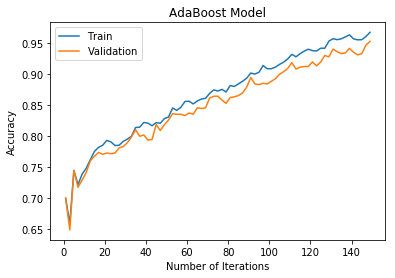

In [9]:
x = models.keys()
train_acc = [acc["train_acc"] for acc in models.values()]
val_acc   = [acc["val_acc"] for acc in models.values()]

# Labels of plot
plt.title("AdaBoost Model")
plt.ylabel("Accuracy")
plt.xlabel("Number of Iterations")

# Plotting train and validation accuracy
plt.plot(x, train_acc, label='Train')
plt.plot(x, val_acc, label='Validation')

plt.legend()
plt.show()

- De acordo com os resultados obtidos acima, podemos perceber que o resultado foi muito bom. Observamos que o aumento de iterações reflete em um aumento da acurácia de forma significativa. Se utilizarmos 20 Stumps o resultado é bem pior do que se usarmos 100 Stumps, por exemplo. <br><br>

- Note que as curvas de validação e treino estão próximas uma das outras, mostrando que não caímos em overfitting, mesmo com um modelo mais complexo, i.e com mais iterações. Isso pode ser explicado devido ao uso de Stumps pelo AdaBoost. Como cada modelo fraco nunca irá sofrer overfitting, por ser extremamente simples, o modelo forte (ensemble) também não sofrerá desse problema.<br><br>

- Para resultados ainda melhores poderíamos ter treinado o modelo por mais iterações. Porém, como esse código foi feito em Python sem nenhuma otimização, como por exemplo o uso da biblioteca Numba, iríamos consumir muito tempo e ter resultados similiares com o que foi mostrado.